In [11]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geodatasets
import os
import ast
import math

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv(os.path.join('data', 'NEI_pollution_source_2020.csv'), dtype={'FIPS':str}, index_col=0)
df.head()

/var/folders/0b/l4__m5492hg2pxtxg6z149mh0000gn/T/ipykernel_39157/3039517931.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join('data', 'NEI_pollution_source_2020.csv'), dtype={'FIPS':str}, index_col=0)


,State,State-County,Pollutant,Emissions (Tons),Pollutant Type,Site Name,EIS Facility ID,Facility Type,Street Address,NAICS,Lat/Lon,EPA Region,FIPS,Lat,Lon
0,Alabama,AL - Autauga,Carbon Dioxide,2.391966e+06,GHG,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,32.650024,-86.738287
1,Alabama,AL - Autauga,Nitrogen Oxides,2.110000e+02,CAP,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,32.650024,-86.738287
2,Alabama,AL - Autauga,Ammonia,1.097200e+02,CAP,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,32.650024,-86.738287
3,Alabama,AL - Autauga,PM2.5 Primary (Filt + Cond),9.240000e+01,CAP,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,32.650024,-86.738287
4,Alabama,AL - Autauga,PM10 Primary (Filt + Cond),9.240000e+01,CAP,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,32.650024,-86.738287


In [3]:
df['Lat/Lon'] = df['Lat/Lon'].apply(ast.literal_eval)
df.head()

,State,State-County,Pollutant,Emissions (Tons),Pollutant Type,Site Name,EIS Facility ID,Facility Type,Street Address,NAICS,Lat/Lon,EPA Region,FIPS,Lat,Lon
0,Alabama,AL - Autauga,Carbon Dioxide,2.391966e+06,GHG,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,32.650024,-86.738287
1,Alabama,AL - Autauga,Nitrogen Oxides,2.110000e+02,CAP,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,32.650024,-86.738287
2,Alabama,AL - Autauga,Ammonia,1.097200e+02,CAP,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,32.650024,-86.738287
3,Alabama,AL - Autauga,PM2.5 Primary (Filt + Cond),9.240000e+01,CAP,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,32.650024,-86.738287
4,Alabama,AL - Autauga,PM10 Primary (Filt + Cond),9.240000e+01,CAP,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,32.650024,-86.738287


In [38]:
file_size = os.path.getsize(os.path.join('data', 'NEI_pollution_source_2020.csv')) / 1e6
# github filesize limit is 50 Mb. Need to split this file into several files to upload them
n_files = math.ceil(file_size / 50)
n_rows = df.shape[0]
row_limit = n_rows // n_files

splits = range(0, n_rows + 1, row_limit)

save_data_dir = os.path.join('data', 'nei_pollution')

if not os.path.exists(save_data_dir):
    os.makedirs(save_data_dir)

for i, start_end in enumerate(zip(splits[:-1], splits[1:])):
    start = start_end[0]
    end = start_end[1]

    file_name = f'NEI_point_source_pollution_{i}.csv'
    df.iloc[start:end, :].to_csv(os.path.join(save_data_dir, file_name))

print('All done!')


All done!


In [34]:
df.iloc[n_rows-1:n_rows+100, :]

,State,State-County,Pollutant,Emissions (Tons),Pollutant Type,Site Name,EIS Facility ID,Facility Type,Street Address,NAICS,Lat/Lon,EPA Region,FIPS,Lat,Lon
1048564,Wyoming,WY - Sweetwater,Hexane,0.216071,HAP,C.G. Road 9-60D PAD,20370011,Unspecified,P.O. Box 157,Oil and Gas Extraction,"[-107.993354, 41.722842]",8,56037,41.722842,-107.993354


In [32]:
locations_df = df[['EIS Facility ID', 'Site Name', 'State', 'Lat', 'Lon']]
locations_df = locations_df.drop_duplicates()
locations_df.head()

# just keep california because trying to cluster eveything seems to crash jupyter
ca_df = locations_df.loc[locations_df['State'] == 'California', :]
ca_df.head()

,EIS Facility ID,Site Name,State,Lat,Lon
39167,18172311,7-11 STORE,California,37.702889,-121.721006
39173,18175311,7-11 STORE #33163,California,37.718678,-121.910240
39179,18366311,7-ELEVEN,California,37.717347,-121.723735
39185,18172511,7-ELEVEN #32734,California,37.698070,-121.772987
39191,18521411,7-ELEVEN INC.,California,37.795672,-122.253424


(0.0, 0.1)

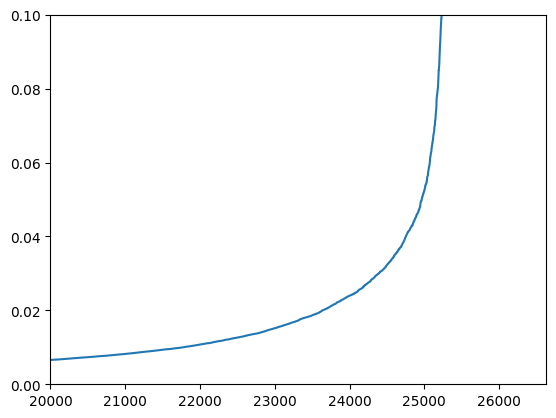

In [33]:
# find nearest neghbbors to tune dbscan
nn = NearestNeighbors(n_neighbors=25)
nn_fit = nn.fit(ca_df[['Lat', 'Lon']])
dist, indices = nn_fit.kneighbors(ca_df[['Lat', 'Lon']])

dist = np.sort(dist, axis=0)
dist = dist[:, 1]
plt.plot(dist)
plt.xlim(20000)
plt.ylim(0, 0.1)

In [34]:
dbscan = DBSCAN(eps=0.03)
ca_df['Cluster'] = dbscan.fit_predict(ca_df[['Lat', 'Lon']])
ca_df['Cluster'] = ca_df['Cluster'].astype(str)
ca_df.head()

/var/folders/0b/l4__m5492hg2pxtxg6z149mh0000gn/T/ipykernel_81458/2350223037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_df['Cluster'] = dbscan.fit_predict(ca_df[['Lat', 'Lon']])
/var/folders/0b/l4__m5492hg2pxtxg6z149mh0000gn/T/ipykernel_81458/2350223037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_df['Cluster'] = ca_df['Cluster'].astype(str)


,EIS Facility ID,Site Name,State,Lat,Lon,Cluster
39167,18172311,7-11 STORE,California,37.702889,-121.721006,0
39173,18175311,7-11 STORE #33163,California,37.718678,-121.910240,0
39179,18366311,7-ELEVEN,California,37.717347,-121.723735,0
39185,18172511,7-ELEVEN #32734,California,37.698070,-121.772987,0
39191,18521411,7-ELEVEN INC.,California,37.795672,-122.253424,1


In [35]:
ca_df.groupby('Cluster').count()

,EIS Facility ID,Site Name,State,Lat,Lon
Cluster,,,,,
-1,2457,2457,2457,2457,2457
0,418,418,418,418,418
1,7595,7595,7595,7595,7595
10,6,6,6,6,6
100,9,9,9,9,9
...,...,...,...,...,...
95,5,5,5,5,5
96,9,9,9,9,9
97,14,14,14,14,14


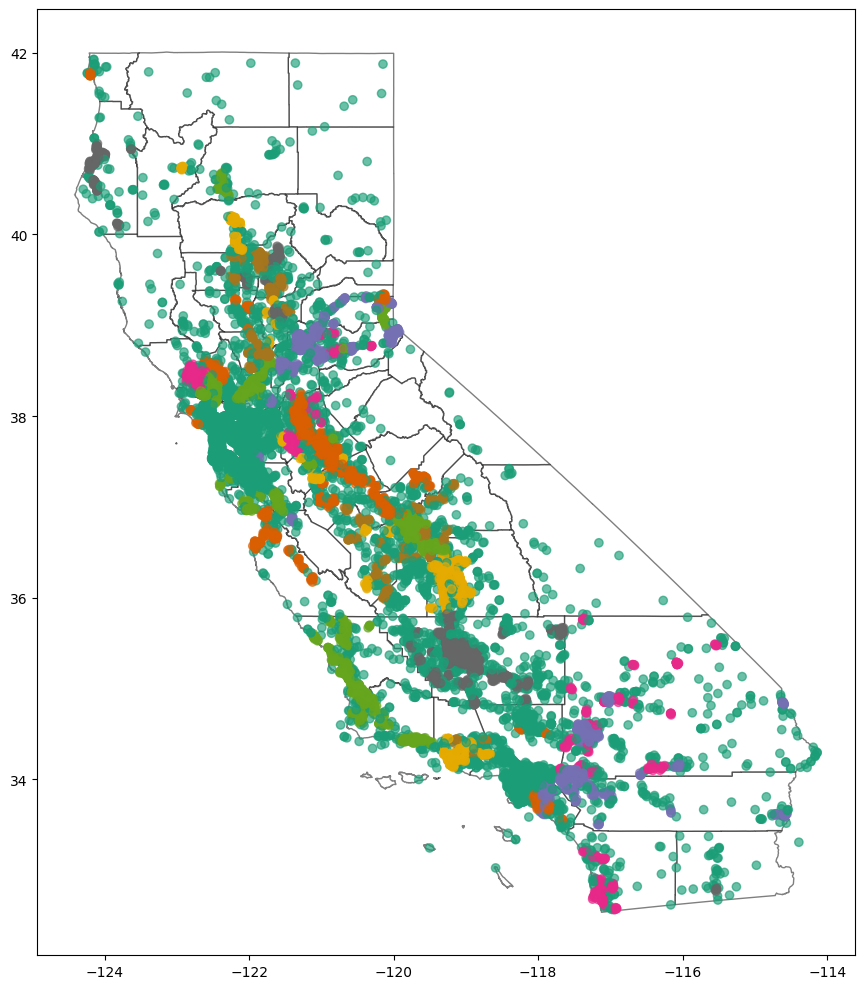

In [36]:
gdf = gpd.GeoDataFrame(ca_df, geometry = gpd.points_from_xy(ca_df.Lon, ca_df.Lat), crs="EPSG:4326")

ca_county_lines = 'California_Counties.geojson'

california = gpd.read_file(os.path.join('data', ca_county_lines))
ax = california.plot(figsize=(10,10), alpha=0.5, edgecolor='k', color='white')

legend = False
gdf.plot(kind='geo', column='Cluster', legend=legend, alpha = 0.65, ax=ax, cmap='Dark2')

if legend:
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((1, 0.5, 0.1, 0.1))

plt.tight_layout()

In [116]:
site_sums_df = df[['EIS Facility ID', 'Emissions (Tons)']].groupby('EIS Facility ID', as_index=False).sum()
site_sums_df = locations_df.merge(site_sums_df, on='EIS Facility ID')
ca_sums_df = site_sums_df.merge(ca_df[['EIS Facility ID', 'Cluster']], on='EIS Facility ID')
ca_sums_df.describe()

,EIS Facility ID,Lat,Lon,Emissions (Tons)
count,2.536600e+04,25366.000000,25366.000000,2.536600e+04
mean,1.304782e+07,36.998224,-120.753437,3.543271e+03
std,6.413190e+06,1.622029,1.693073,8.161310e+04
min,1.110000e+02,32.562466,-124.294220,1.500000e-12
25%,1.005119e+07,35.771619,-122.073135,1.717246e-02
50%,1.437416e+07,37.464456,-121.283075,1.219687e-01
75%,1.841509e+07,37.952801,-119.560837,6.722814e-01
max,2.148311e+07,41.927260,-114.139670,6.198461e+06


<Axes: xlabel='Emissions (Tons)', ylabel='Percent'>

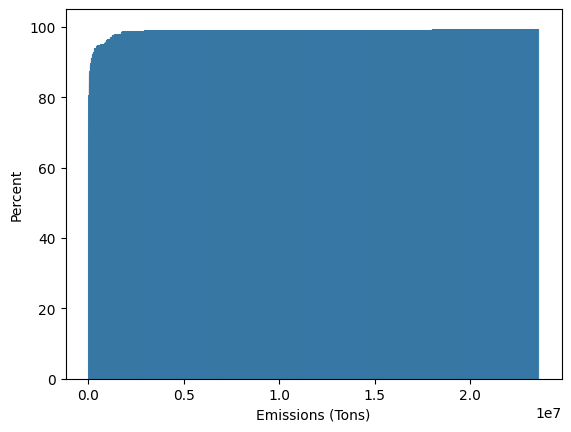

In [117]:
ca_cluster_df = ca_sums_df.loc[:, 'Emissions (Tons)':].groupby('Cluster').sum()
total_emissions = ca_cluster_df['Emissions (Tons)'].sum()
ca_cluster_df['Percent of Total Emissions'] = ca_cluster_df['Emissions (Tons)'] / total_emissions
ca_cluster_df['Emissions (kTons)'] = ca_cluster_df['Emissions (Tons)'] / 1000
cum_percent_total_emissions = np.cumsum(ca_cluster_df['Percent of Total Emissions'].sort_values())
# sns.lineplot(y = cum_percent_total_emissions, x = cum_percent_total_emissions.index)
sns.histplot(ca_cluster_df, x='Emissions (Tons)', cumulative=True, stat='percent')

In [118]:
ca_cluster_df

,Emissions (Tons),Percent of Total Emissions,Emissions (kTons)
Cluster,,,
-1,1.800265e+07,2.002996e-01,18002.646843
0,2.042408e+04,2.272408e-04,20.424082
1,2.361008e+07,2.626886e-01,23610.081649
10,4.734799e+00,5.267993e-08,0.004735
100,2.790769e+00,3.105042e-08,0.002791
...,...,...,...
95,9.789080e+00,1.089145e-07,0.009789
96,7.702174e+03,8.569530e-05,7.702174
97,7.138932e+00,7.942860e-08,0.007139


In [119]:
ca_cluster_df.quantile([0.75, 0.8, 0.9, 0.95, 0.99])

,Emissions (Tons),Percent of Total Emissions,Emissions (kTons)
0.75,7.123475e+03,0.000079,7.123475
0.80,1.557023e+04,0.000173,15.570232
0.90,1.240378e+05,0.001380,124.037815
0.95,5.207049e+05,0.005793,520.704870
0.99,2.553903e+06,0.028415,2553.903487


In [120]:
ca_cluster_df.loc[ca_cluster_df['Emissions (Tons)'] > 521, :].sum()

Emissions (Tons)              8.987117e+07
Percent of Total Emissions    9.999173e-01
Emissions (kTons)             8.987117e+04
dtype: float64

In [121]:
ca_cluster_df.loc['225', :]

Emissions (Tons)              1.736196e+06
Percent of Total Emissions    1.931713e-02
Emissions (kTons)             1.736196e+03
Name: 225, dtype: float64

In [122]:
# top 10 emissions
top_clusters = ca_cluster_df.sort_values('Percent of Total Emissions', ascending=False).iloc[:10, :].index
top_clusters

Index(['122', '1', '-1', '197', '81', '225', '155', '224', '107', '89'], dtype='object', name='Cluster')

In [123]:
total_emissions

np.float64(89878601.15747397)

<Axes: xlabel='Emissions (kTons)', ylabel='Cluster'>

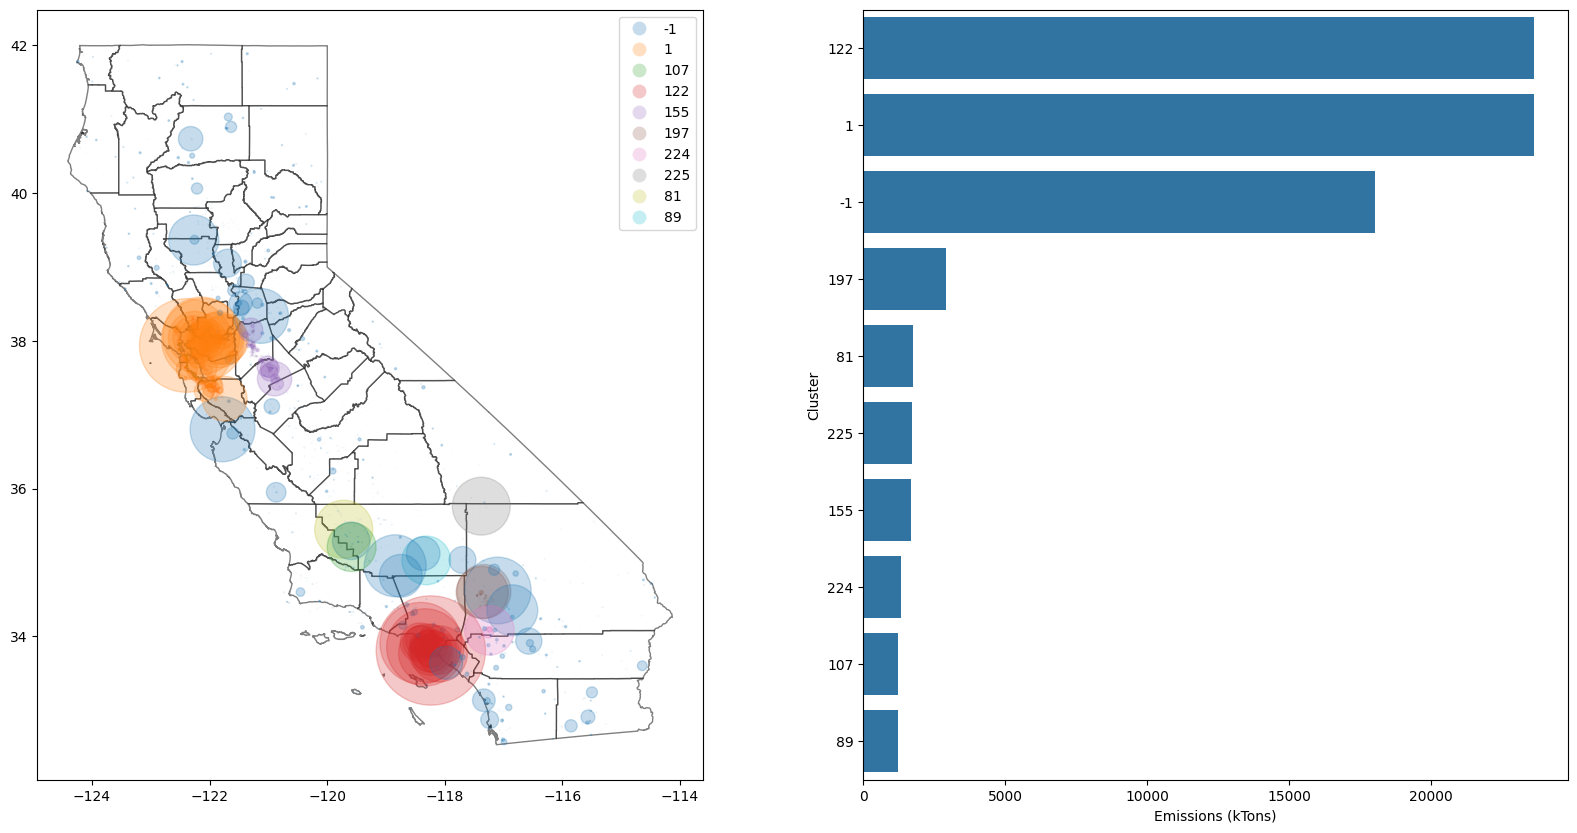

In [129]:
top_clusters_df = ca_df.loc[ca_df.Cluster.isin(top_clusters), :]

cluster_emissions_df = top_clusters_df.merge(sum_df, on='EIS Facility ID')
cluster_emissions_df = cluster_emissions_df.drop_duplicates(subset = 'EIS Facility ID')
cluster_emissions_df['Emissions (kTons)'] = cluster_emissions_df['Emissions (Tons)'] / 1000

gdf = gpd.GeoDataFrame(cluster_emissions_df, geometry = gpd.points_from_xy(cluster_emissions_df.Lon, cluster_emissions_df.Lat), crs="EPSG:4326")

ca_county_lines = 'California_Counties.geojson'

california = gpd.read_file(os.path.join('data', ca_county_lines))

fig, axes = plt.subplots(1, 2, figsize=(20,10))

ax_map = axes[0]

california.plot(alpha=0.5, edgecolor='k', color='white', ax = ax_map)

legend = True
gdf.plot(kind='geo', column='Cluster', legend=legend, alpha = 0.25, ax=ax_map, cmap='tab10', markersize='Emissions (kTons)')

# bar chart next to map
ax_bar = axes[1]

bar_plot_df = cluster_emissions_df.groupby('Cluster', as_index=False).sum().reset_index()
bar_plot_df = bar_plot_df.sort_values('Emissions (kTons)', ascending=False)
sns.barplot(bar_plot_df, x='Emissions (kTons)', y='Cluster', ax=ax_bar)
# ax_bar.vlines(total_emissions / 1000, ymin='149', ymax='225')

# plt.tight_layout()

In [125]:
cluster_emissions_df

,EIS Facility ID,Site Name,State,Lat,Lon,Cluster,Emissions (Tons),Emissions (kTons)
0,18521411,7-ELEVEN INC.,California,37.795672,-122.253424,1,0.228374,0.000228
1,18172911,7-ELEVEN STORE #18916,California,37.570452,-122.032385,1,0.527636,0.000528
2,18525211,7-ELEVEN STORE #35341,California,37.665608,-122.113580,1,0.440167,0.000440
3,19278411,7TH STREET PROPERTIES,California,37.852502,-122.292230,1,0.023029,0.000023
4,19278511,7TH STREET PROPERTIES II,California,37.852384,-122.293652,1,0.052219,0.000052
...,...,...,...,...,...,...,...,...
12746,20979211,SUPER POWER MART II,California,39.328025,-121.342485,-1,0.282018,0.000282
12747,3698011,US PIPE AND FABRICATION,California,39.030445,-121.522277,-1,3.953734,0.003954
12748,15708611,"VISHAAN, INC",California,39.228710,-121.413220,-1,0.634038,0.000634
12749,15914511,WHEATLAND CHEVRON,California,39.014210,-121.431660,-1,1.092341,0.001092


In [109]:
ca_cluster_df.sort_values('Percent of Total Emissions')

,Emissions (Tons),Percent of Total Emissions,Emissions (kTons)
Cluster,,,
160,0.002506,1.686841e-09,0.000003
256,0.004079,2.745382e-09,0.000004
254,0.007430,5.001430e-09,0.000007
136,0.014670,9.874356e-09,0.000015
144,0.020434,1.375486e-08,0.000020
...,...,...,...
107,103128.322842,6.941785e-02,103.128323
235,132793.671461,8.938622e-02,132.793671
81,134637.353834,9.062724e-02,134.637354


In [100]:
cluster_emissions_df.loc[cluster_emissions_df['Cluster']=='287']

,EIS Facility ID,Site Name,State,Lat,Lon,Cluster,Emissions (Tons),Emissions (kTons)
94,18161611,AMERICAN TOWERS LLC,California,37.415500,-121.156985,287,0.009207,0.000009
95,6592611,"COVANTA STANISLAUS, INC",California,37.385380,-121.140880,287,305435.014496,305.435014
96,14121211,"COVANTA STANISLAUS, INC",California,37.389990,-121.119997,287,0.010811,0.000011
97,1370511,FINK ROAD LANDFILL,California,37.397046,-121.140045,287,1553.819352,1.553819
98,9880811,PHILLIPS 66 PIPELINE LLC,California,37.420224,-121.150022,287,16.043503,0.016044


In [113]:
cluster_emissions_df.groupby('Cluster').sum().sort_values('Emissions (kTons)')

,EIS Facility ID,Site Name,State,Lat,Lon,Emissions (Tons),Emissions (kTons)
Cluster,,,,,,,
287,50126755,"AMERICAN TOWERS LLCCOVANTA STANISLAUS, INCCOVA...",CaliforniaCaliforniaCaliforniaCaliforniaCalifo...,187.008140,-605.707929,3.070049e+05,307.004897
73,21678566,EL CENTROIMPERIAL IRRIGATION DISTRICT ECGSNAVA...,CaliforniaCaliforniaCaliforniaCaliforniaCalifo...,196.729466,-693.238406,3.216285e+05,321.628500
192,153653199,B B TRAVEL CENTERBlytheBLYTHE AIRPORTBLYTHE EN...,CaliforniaCaliforniaCaliforniaCaliforniaCalifo...,302.514123,-1032.374334,8.448962e+05,844.896205
236,104319676,CALPEAK POWER ENTERPRISE LLCCITY OF ESCONDIDOE...,CaliforniaCaliforniaCaliforniaCaliforniaCalifo...,529.945370,-1873.655387,8.750991e+05,875.099132
235,75660477,CALPEAK POWER BORDER LLCLARKSPUR ENERGY FACILI...,CaliforniaCaliforniaCaliforniaCaliforniaCalifo...,228.021585,-818.488642,9.295557e+05,929.555700
89,153235499,ALTA WIND IIALTA WIND IIALTA WIND LLC (PHASE V...,CaliforniaCaliforniaCaliforniaCaliforniaCalifo...,315.309588,-1064.550136,1.230867e+06,1230.867184
107,69003632,ALMOND CREST OIL LLCCHEVRON USA INCCHEVRON USA...,CaliforniaCaliforniaCaliforniaCaliforniaCalifo...,422.381278,-1434.770116,1.237540e+06,1237.539874
224,154989076,BURLINGTON NORTHERN/SANTA FE RAILWAY COCOSTCO ...,CaliforniaCaliforniaCaliforniaCaliforniaCalifo...,545.265866,-1876.223936,1.346394e+06,1346.393920
225,97095966,FRONTIER - GC# 747INDUSTRIAL STORESBCO FIRE ST...,CaliforniaCaliforniaCaliforniaCaliforniaCalifo...,214.555361,-704.256252,1.736196e+06,1736.196395


In [114]:
total_emissions

np.float64(1485616.784204224)